Filtered and Sorted real data:
    learning_rate  batch_size  hidden_dim  num_layers  num_heads  \
0         0.0001          64         256           3         16   
1         0.0001          64         256           3         16   
2         0.0001          64         128           3         16   
3         0.0001          64         256           3          4   
4         0.0001          64         128           3          4   

   contrastive_dim   k  best_val_loss  
0              512  90       0.004896  
1               64  90       0.004916  
2               64  90       0.005123  
3               64  90       0.005325  
4              512  48       0.005354  


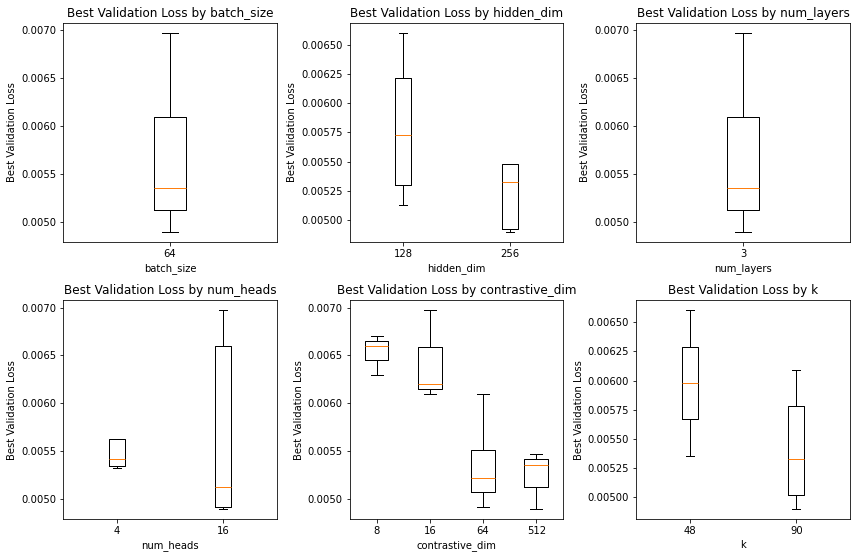

In [20]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def collect_results(root_dir):
    """
    Walk through 'root_dir', parse each folder named like:
      results_lr{lr}_bs{bs}_hd{hd}_nl{nl}_nh{nh}_cd{cd}_k{k}
    Extract the best training loss from the corresponding CSV:
      results_lr{lr}_bs{bs}_hd{hd}_nl{nl}_nh{nh}_cd{cd}_k{k}.csv
    but keep the variable naming and plotting labels as if they were showing validation loss.
    Return a DataFrame containing the hyperparameters + best_val_loss.
    """
    all_results = []
    
    for folder in os.listdir(root_dir):
        if folder.startswith("results_"):
            folder_path = os.path.join(root_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            csv_file = os.path.join(folder_path, folder + ".csv")
            if not os.path.exists(csv_file):
                continue

            # Read CSV and obtain the best training loss (stored as best_val_loss for plotting)
            df = pd.read_csv(csv_file)
            best_val_loss = df["train_loss"].min()  # Using training loss

            # Adjusted regex for folders with 'nh' (num_heads)
            match = re.match(
                r"results_lr(.+)_bs(.+)_hd(.+)_nl(.+)_nh(.+)_cd(.+)_k(.+)",
                folder
            )
            if match:
                lr_str, bs_str, hd_str, nl_str, nh_str, cd_str, k_str = match.groups()
                all_results.append({
                    "learning_rate": float(lr_str),
                    "batch_size": int(bs_str),
                    "hidden_dim": int(hd_str),
                    "num_layers": int(nl_str),
                    "num_heads": int(nh_str),  # New parameter for GAT
                    "contrastive_dim": int(cd_str),
                    "k": int(k_str),
                    "best_val_loss": best_val_loss
                })

    return pd.DataFrame(all_results)

def main():
    # 1) Collect real data from your GAT results folders
    root_dir = "/vols/cms/mm1221/hgcal/elec5New/Track/Hyperparam/results/Trans/"
    df = collect_results(root_dir)

    # 2) Filter out invalid or large loss values
    df = df[df["best_val_loss"].notna()]   # remove NaNs
    df = df[df["best_val_loss"] <= 0.007]       # filter runs with loss > 11
    df = df.reset_index(drop=True)

    # 2a) Sort the table by best_val_loss (lowest training loss is best)
    df = df.sort_values("best_val_loss", ascending=True)
    df = df.reset_index(drop=True)

    print("Filtered and Sorted real data:\n", df.head())

    # 4) List of hyperparameters to visualize (with num_heads as the 4th plot)
    hyperparams = ["batch_size", "hidden_dim", "num_layers", "num_heads", "contrastive_dim", "k"]

    # 5) Create subplots for the six box plots (e.g., a 2x3 grid)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    axes = axes.flatten()

    ##########################################################################
    # 6) For each parameter, build the distribution for each group and add custom data.
    ##########################################################################
    for idx, param in enumerate(hyperparams):
        ax = axes[idx]

        # Group real data by the current parameter: map each parameter value to its list of best_val_loss values.
        grouped = df.groupby(param)["best_val_loss"].apply(list).to_dict()

        # Merge in any custom points for this parameter, if provided.
        if param in custom_points:
            for param_value, extra_vals in custom_points[param].items():
                if param_value not in grouped:
                    grouped[param_value] = []
                grouped[param_value].extend(extra_vals)

        # Sort parameter values to maintain consistent order on the x-axis.
        sorted_param_values = sorted(grouped.keys())
        data_for_boxplot = [grouped[val] for val in sorted_param_values]

        # If there's no data for this parameter, indicate that.
        if len(data_for_boxplot) == 0:
            ax.set_title(f"No data for {param}")
            ax.set_visible(True)
            continue

        # Create the box plot while hiding outlier markers.
        ax.boxplot(data_for_boxplot, labels=sorted_param_values, showfliers=False)
        ax.set_title(f"Best Validation Loss by {param}")
        ax.set_xlabel(param)
        ax.set_ylabel("Best Validation Loss")

    # Hide any leftover subplots if there are more axes than hyperparameters.
    for j in range(len(hyperparams), len(axes)):
        axes[j].set_visible(False)

    # Tidy up the layout.
    fig.suptitle("")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
